## Prophet Forcasting

In this notebook we will use Prohphet Library that provide completely automated forecast, and to tune the parameters of the prophet model we will use Optuna to automatize the tuninng of parameters.





In other terms this notebook will be about using a library which will automate the forecasting

In [21]:
import pandas as pd
import numpy as np
from prophet import Prophet
import optuna
from prophet.diagnostics import performance_metrics
from prophet.diagnostics import cross_validation
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt
import joblib
import glob

#### Global Var :

In [22]:
PATH = r'C:\Users\Zakaria Bouchegoura\Desktop\Nouveau dossier (5)\archive\stock_market_data\nasdaq\csv'
n_trials = 10 # Number of trials by optuna to find the optimal parameters

### Loading All Stock Market :

For correct usage of prophet.lib its require to put the index of the dataset as Date.time type and use only two clomuns 

ds = date and y = close price

In [23]:
# getting path's of all datasets
datasets_files = glob.glob(PATH + "/*.csv")

datasets = {} # dictionary to save each stock-market dataset by its Index

for filename in datasets_files:
    stock_name=filename.split("\\")[-1][:-4] #getting the Index of the stock
    df = pd.read_csv(filename, index_col=None, header=0)
    datetime_series = pd.to_datetime(df['Date'],dayfirst=True)
    datetime_index = pd.DatetimeIndex(datetime_series.values)
    df["Date"]=datetime_series
    df2=df.set_index(datetime_index)
    df2.drop(['Low', 'Open', 'Volume', 'High', 'Adjusted Close'], axis=1, inplace=True)
    df2.columns=['ds','y']
    df2=df2.dropna()
    datasets[stock_name]=df2

In [24]:
# adding to the global environment, global variables of each stock market called by its stock index
locals().update(datasets) 

#### chosing one Stock for the study

The prediction and optimization process takes about 5 min per action for 10 trials.

The task is time-consuming, we will conduct the study on a single stock market action and we choose Apple Stock.

The idea will be the same for the rest of stocks.

In [25]:
data=AAPL.copy()

In [26]:
data

,ds,y
1980-12-12,1980-12-12,0.128348
1980-12-15,1980-12-15,0.121652
1980-12-16,1980-12-16,0.112723
1980-12-17,1980-12-17,0.115513
1980-12-18,1980-12-18,0.118862
...,...,...
2022-05-31,2022-05-31,148.839996
2022-06-01,2022-06-01,148.710007
2022-06-02,2022-06-02,151.210007
2022-06-03,2022-06-03,145.380005


#### Preparing Optuna 

We define a function who take the parameters that we want tune for the model Prophet, we use the mean average error to compare the different models.

In [39]:
def objective(trial):

    """ 
    trials = Number of trials by optuna to find the optimal parameters
    
    """
    # params contains the parameters that we want tune for the model

    params = {
        'changepoint_prior_scale': trial.suggest_float('changepoint_prior_scale', 0.005, 10),
        'changepoint_range': trial.suggest_float('changepoint_range', 0.05, 0.99),
        'seasonality_prior_scale': trial.suggest_float('seasonality_prior_scale', 0.05, 10),
        'holidays_prior_scale': trial.suggest_float('holidays_prior_scale', 0.1, 100),
        'seasonality_mode': trial.suggest_categorical('seasonality_mode', ['multiplicative', 'additive']),
        'weekly_seasonality': trial.suggest_int('weekly_seasonality', 1, 200),
        'yearly_seasonality': trial.suggest_int('yearly_seasonality', 1, 20),
    }
    
    model = Prophet(**params) # model is Prophet class object
    model.fit(data['2017-01-01':'2022-05-20'])
    preds = model.predict(data)
    
    mae_score = mean_absolute_percentage_error(data['y'], preds['yhat'])
    return mae_score

#### Initiate optuna with 10 trials.

In [40]:
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=n_trials)

[I 2022-10-17 20:04:23,618] A new study created in memory with name: no-name-79c4141e-d80a-41b6-bda2-54b73961e690
20:04:24 - cmdstanpy - INFO - Chain [1] start processing
20:04:27 - cmdstanpy - INFO - Chain [1] done processing
[I 2022-10-17 20:04:30,349] Trial 0 finished with value: 6544.914563444513 and parameters: {'changepoint_prior_scale': 4.456294826423114, 'changepoint_range': 0.33581289652037233, 'seasonality_prior_scale': 8.00580156656998, 'holidays_prior_scale': 19.054728656525967, 'seasonality_mode': 'additive', 'weekly_seasonality': 49, 'yearly_seasonality': 3}. Best is trial 0 with value: 6544.914563444513.
20:04:30 - cmdstanpy - INFO - Chain [1] start processing
20:04:31 - cmdstanpy - INFO - Chain [1] done processing
[I 2022-10-17 20:04:34,128] Trial 1 finished with value: 8128.202766581334 and parameters: {'changepoint_prior_scale': 5.011844797748207, 'changepoint_range': 0.5167210679091033, 'seasonality_prior_scale': 3.5684241067700047, 'holidays_prior_scale': 22.0938917

In [41]:
dict_best=study.best_params # Getting the best parameter with smallest MAE

In [42]:
dict_best

{'changepoint_prior_scale': 5.516913042308222,
 'changepoint_range': 0.36731468569642506,
 'seasonality_prior_scale': 4.838446346435458,
 'holidays_prior_scale': 10.680080669158338,
 'seasonality_mode': 'multiplicative',
 'weekly_seasonality': 38,
 'yearly_seasonality': 15}

#### Fitting a prophet with best parameters

20:06:42 - cmdstanpy - INFO - Chain [1] start processing
20:07:43 - cmdstanpy - INFO - Chain [1] done processing


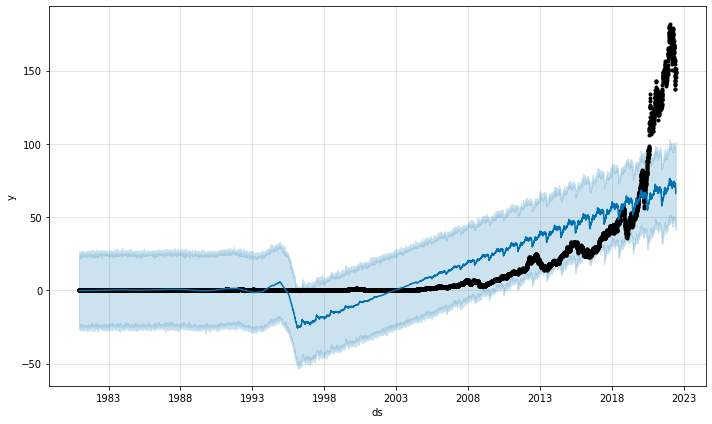

In [49]:
final_model = Prophet(**dict_best)
final_model.fit(data)
forecast = final_model.predict(data)
fig1 = final_model.plot(forecast)

#### Saving the prediction values to plot

In [62]:
prediction=forecast['yhat'][-5:].values
prediction_low=forecast['yhat_lower'][-5:].values
prediction_up=forecast['yhat_upper'][-5:].values


In [63]:
real_values=data['2022-05-28':'2022-06-06']['y'].values
index_prediction=data['2022-05-28':'2022-06-06'].index

In [65]:
study=pd.DataFrame({'prediction':prediction,'prediction_low':prediction_low,'prediction_upper':prediction_up,'real':real_values}
                    ,index=index_prediction)

Comparing and ploting the forecasting and real values

In [66]:
study[['prediction','real']]

,prediction,real
2022-05-31,71.148958,148.839996
2022-06-01,70.438857,148.710007
2022-06-02,69.586281,151.210007
2022-06-03,68.084745,145.380005
2022-06-06,66.162377,148.410004


<AxesSubplot:>

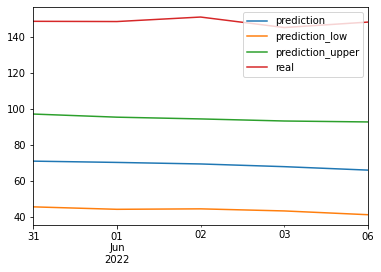

In [67]:
study.plot.line()

I Conclude that prophet is not very efficient at this lim